In [9]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def roundTime(dt=None):    
    dt = dt.to_pydatetime()
    roundTo = 15*60    
    if dt == None : dt = datetime.datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

In [11]:
def conv_entries(arr):  
    int_arr = [int(x) for x in arr]
    if int_arr[2] > 29:
        int_arr[1] += 1        
    int_arr[2] = 0
    mins = int_arr[0]*60 + int_arr[1]
    rem = mins % 15
    if rem > 7:
        mins += (15-rem)
    else:
        mins -= rem        
    return mins

In [12]:
def calc_quarter_load(row):
    dur = row['Charging Time (hh:mm:ss)']
    total = row['Energy (kWh)']
    return (total/dur)*15.0

In [13]:
def add_to_backbone(row):
    iters = row['Charging Time (hh:mm:ss)']//15
    for i in range(iters):
        backbone.loc[backbone['date_time'] == row['Start Date'] + datetime.timedelta(minutes=15*i), 'value'] += row['Load_per_quarter']  
        backbone.loc[backbone['date_time'] == row['Start Date'] + datetime.timedelta(minutes=15*i), 'sessions'] += 1    

In [14]:
mode = "rapid"
#mode = "fast"


df_palo_alto = pd.read_csv (r'/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/ElectricVehicleChargingStationUsageJuly2011Dec2020_PaloAlto.csv')
exclude_stations = ["PALO ALTO CA / TED THOMPSON #4","PALO ALTO CA / TED THOMPSON #3","PALO ALTO CA / CAMBRIDGE #5","PALO ALTO CA / TED THOMPSON #2","PALO ALTO CA / CAMBRIDGE #3","PALO ALTO CA / CAMBRIDGE #4","PALO ALTO CA / BRYANT # 1","PALO ALTO CA / SHERMAN 6","PALO ALTO CA / SHERMAN 7","PALO ALTO CA / SHERMAN 9","PALO ALTO CA / SHERMAN 8","PALO ALTO CA / SHERMAN 4","PALO ALTO CA / SHERMAN 1","PALO ALTO CA / SHERMAN 3","PALO ALTO CA / SHERMAN 14","PALO ALTO CA / SHERMAN 2","PALO ALTO CA / SHERMAN 5","PALO ALTO CA / SHERMAN 15","PALO ALTO CA / SHERMAN 11","PALO ALTO CA / SHERMAN 17"]

df_palo_alto = df_palo_alto[df_palo_alto['Station Name'].isin(exclude_stations) == False]

if mode == "rapid":
    df_palo_alto = df_palo_alto[df_palo_alto['Plug Type'] == 'J1772']
else: 
    df_palo_alto = df_palo_alto[df_palo_alto['Plug Type'] == 'NEMA 5-20R']

df_palo_alto = df_palo_alto[df_palo_alto['Start Date'].notna()]
df_palo_alto = df_palo_alto[df_palo_alto['Charging Time (hh:mm:ss)'].notna()]

/tmp/ipykernel_41825/3061355055.py:5: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_palo_alto = pd.read_csv (r'/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/ElectricVehicleChargingStationUsageJuly2011Dec2020_PaloAlto.csv')


In [15]:
min(df_palo_alto['Start Date'])

'1/1/2012 13:24'

In [7]:
cutoff = datetime.datetime.strptime("8/1/2017 00:00", '%m/%d/%Y %H:%M')
df_palo_alto['Start Date'] = df_palo_alto['Start Date'].map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M'))
df_palo_alto = df_palo_alto[df_palo_alto['Start Date'] >= cutoff]
df_palo_alto = df_palo_alto[df_palo_alto['Energy (kWh)'] > 0.0]

Timestamp('2017-08-01 05:16:00')

In [24]:
df_palo_alto['Charging Time (hh:mm:ss)'] = df_palo_alto['Charging Time (hh:mm:ss)'].map(lambda x: x.split(':'))
df_palo_alto['Charging Time (hh:mm:ss)'] = df_palo_alto['Charging Time (hh:mm:ss)'].map(conv_entries)
df_palo_alto = df_palo_alto[df_palo_alto['Charging Time (hh:mm:ss)'] > 0]
df_palo_alto['Load_per_quarter'] = df_palo_alto.apply(lambda row: calc_quarter_load(row), axis=1)

In [25]:
df_palo_alto['Start Date'] = df_palo_alto['Start Date'].dt.to_pydatetime()
df_palo_alto['Start Date'] = df_palo_alto['Start Date'].map(roundTime)
start = df_palo_alto['Start Date'].min()
start = cutoff
# start = datetime.datetime.strptime("2020/03/15 00:00:00+00", '%Y/%m/%d %H:%M:%S+%f') 
end = datetime.datetime.strptime("2020/03/15 00:00:00+00", '%Y/%m/%d %H:%M:%S+%f')
# end = df_palo_alto['Start Date'].max()

In [26]:
backbone = pd.DataFrame({'date_time': pd.date_range(start, end, freq="15min")})
backbone.set_index('date_time')
backbone['value'] = 0.0
backbone['sessions'] = 0

In [27]:
list(df_palo_alto)


['Station Name',
 'MAC Address',
 'Org Name',
 'Start Date',
 'Start Time Zone',
 'End Date',
 'End Time Zone',
 'Transaction Date (Pacific Time)',
 'Total Duration (hh:mm:ss)',
 'Charging Time (hh:mm:ss)',
 'Energy (kWh)',
 'GHG Savings (kg)',
 'Gasoline Savings (gallons)',
 'Port Type',
 'Port Number',
 'Plug Type',
 'EVSE ID',
 'Address 1',
 'City',
 'State/Province',
 'Postal Code',
 'Country',
 'Latitude',
 'Longitude',
 'Currency',
 'Fee',
 'Ended By',
 'Plug In Event Id',
 'Driver Postal Code',
 'User ID',
 'County',
 'System S/N',
 'Model Number',
 'Load_per_quarter']

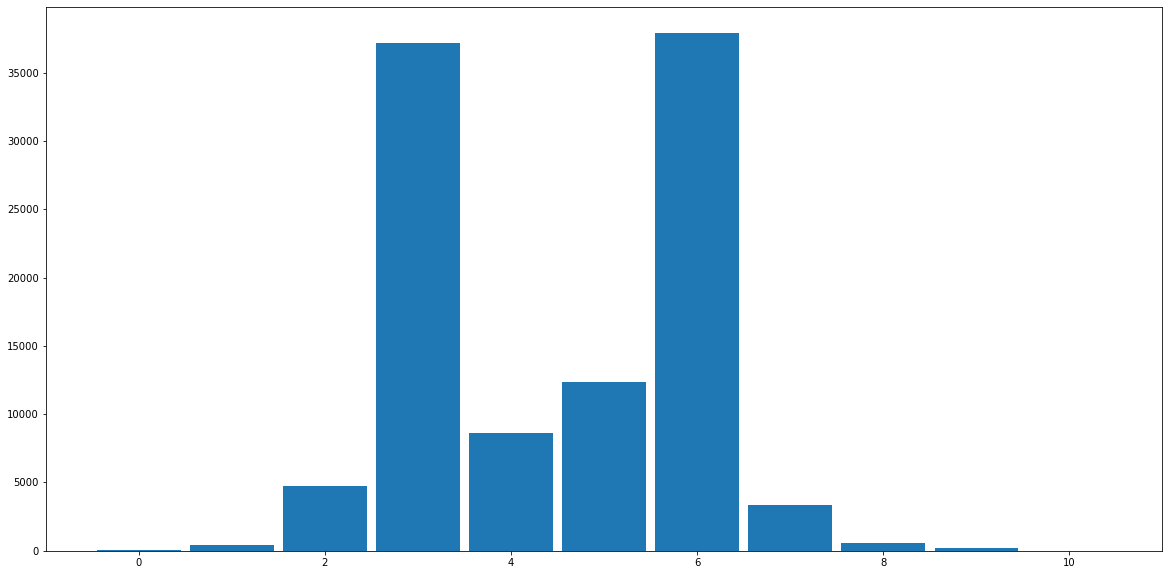

In [28]:
def calc_power(row):
    dur = row['Charging Time (hh:mm:ss)']
    energy = row['Energy (kWh)']
    return round((energy/dur)*60)
    
df_palo_alto['power'] = df_palo_alto.apply(lambda row: calc_power(row), axis=1)


list(df_palo_alto)
np.mean(df_palo_alto.power)

vc_power = df_palo_alto.power.value_counts()
vc_power = vc_power.sort_index()
vc_power = vc_power[:11]
x_power = vc_power.index
y_power = vc_power.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_power, y_power, width=0.9)
plt.show()

In [29]:
vc_power[:11]


0        28
1       460
2      4734
3     37158
4      8632
5     12360
6     37898
7      3333
8       548
9       170
10        2
Name: power, dtype: int64

In [30]:
df_palo_alto.apply(lambda row: add_to_backbone(row), axis=1)

KeyboardInterrupt: 

In [ ]:
from scipy import stats
df_palo_alto['z_score'] = np.abs(stats.zscore(df_palo_alto['Charging Time (hh:mm:ss)']))
df_palo_alto = df_palo_alto[df_palo_alto.z_score <= 3.0]

In [ ]:
backbone_daily = pd.DataFrame({'date_time': pd.date_range(start, end, freq="24h")})
backbone_daily['value'] = 0.0
backbone_daily = backbone_daily[:-1]


    
for row in backbone_daily.itertuples():
    avg = 0.0
    start_time = backbone_daily.at[row.Index, 'date_time']
    for i in range(96):
        avg += backbone[backbone['date_time'] == start_time + datetime.timedelta(minutes=15*i)]['value'].item()    
    avg /= 96.0
    backbone_daily.loc[row.Index, 'value'] = avg    
    


In [ ]:
import matplotlib.pyplot as plt

df_palo_alto['Energy__Wh_'] = df_palo_alto['Energy (kWh)'].apply(lambda x: round(int(x*1000)/100)*100)
vc_energy = df_palo_alto.Energy__Wh_.value_counts()
vc_energy = vc_energy.sort_index()

x_energy = vc_energy.index
y_energy = vc_energy.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_energy, y_energy, width=100)
plt.xlabel("Wh")
plt.ylabel("count")
plt.title("energy consumed")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/palo_alto_energy.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

df_palo_alto['Energy__Wh_'] = df_palo_alto['Energy (kWh)'].apply(lambda x: round(int(x*1000)/100)*100)
vc_energy = df_palo_alto.Energy__Wh_.value_counts()
vc_energy = vc_energy.sort_index()

x_energy = vc_energy.index
y_energy = vc_energy.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_energy, y_energy, width=100)
plt.xlabel("Wh")
plt.ylabel("count")
plt.title("energy consumed")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/palo_alto_energy.png')
plt.show()

In [ ]:
df_palo_alto['Start Date']

def get_hs_and_mins(ts):
    hours = str(ts.hour)
    minutes = str(ts.minute)
    if hours == '0':
        hours = '00'
    if minutes == '0':
        minutes = '00'        
    ts = datetime.datetime.strptime(hours + ":" + minutes, '%H:%M')    
    return ts
    
df_palo_alto['plugin_time'] = df_palo_alto['Start Date'].map(get_hs_and_mins)
vc_plugin = df_palo_alto.plugin_time.value_counts()
vc_plugin = vc_plugin.sort_index()


x_plugin = vc_plugin.index
x_plugin = range(96)
y_plugin = vc_plugin.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_plugin, y_plugin, width=0.9)
plt.xlabel("timeslot")
plt.ylabel("count")
plt.title("plugin time")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/palo_alto_plugin_time.png')
plt.show()

In [ ]:
vc_duration = df_palo_alto['Charging Time (hh:mm:ss)'].value_counts()
vc_duration = vc_duration.sort_index()
x_duration = vc_duration.index
y_duration = vc_duration.values

plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_duration, y_duration,width=13)

plt.xlabel("minutes")
plt.ylabel("count")
plt.title("session duration")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/palo_alto_session_duration.png')
plt.show()

In [ ]:


plt.boxplot(df_palo_alto['Charging Time (hh:mm:ss)'])
# plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (all)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/palo_alto_box_all.png')
plt.show()

In [ ]:
def get_weekend(ts):
    if ts.weekday() > 4:
        return 1
    return 0


df_palo_alto['weekend'] = df_palo_alto['Start Date'].apply(get_weekend)

df_palo_alto_weekday = df_palo_alto[df_palo_alto['weekend'] == 0]
df_palo_alto_weekend = df_palo_alto[df_palo_alto['weekend'] == 1]


plt.boxplot(df_palo_alto_weekday['Charging Time (hh:mm:ss)'])
#plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (weekday)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/palo_alto_box_weekday.png')
plt.show()

In [ ]:
plt.boxplot(df_palo_alto_weekend['Charging Time (hh:mm:ss)'])
# plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (weekend)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/palo_alto_box_weekend.png')
plt.show()

In [ ]:
value_dict = {'weekday': df_palo_alto_weekday['Charging Time (hh:mm:ss)'], 'weekend': df_palo_alto_weekend['Charging Time (hh:mm:ss)'], 'all': df_palo_alto['Charging Time (hh:mm:ss)']}

fig, ax = plt.subplots()
ax.boxplot(value_dict.values())
ax.set_xticklabels(value_dict.keys())
plt.rcParams["figure.figsize"] = (20,10)
plt.ylabel("minutes")
plt.title("session duration") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/palo_alto_boxes.png')
plt.show()

In [ ]:
backbone_daily = pd.DataFrame({'date_time': pd.date_range(start, end, freq="24h")})
backbone_daily.set_index('date_time')
backbone_daily['value'] = 0.0
backbone_daily['sessions'] = 0
backbone_daily = backbone_daily[:-1]

for row in backbone_daily.itertuples():
    avg_load = 0.0
    avg_sessions = 0
    start_time = backbone_daily.at[row.Index, 'date_time']
    for i in range(96):
        avg_load += backbone[backbone['date_time'] == start_time + datetime.timedelta(minutes=15*i)]['value'].item()    
        avg_sessions += backbone[backbone['date_time'] == start_time + datetime.timedelta(minutes=15*i)]['sessions'].item()
    avg_load /= 96.0    
    backbone_daily.loc[row.Index, 'value'] = avg_load  
    backbone_daily.loc[row.Index, 'sessions'] = avg_sessions  

In [ ]:
x_sessions = backbone_daily['date_time']
y_sessions = backbone_daily['sessions']
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(x_sessions, y_sessions)
plt.xlabel("time")
plt.ylabel("count")
plt.title("number of charging sessions")
plt.show()

In [ ]:



x = backbone_daily['date_time']
y = backbone_daily['value']  


plt.rcParams["figure.figsize"] = (20,3)
plt.plot(x, y)
plt.show()